# Algorithms

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# UCB-Inspired Adaptive Epsilon-Greedy
# ==========================
class UCB_Inspired_Adaptive_Epsilon_Greedy:
    """
    Epsilon-Greedy variant with UCB-inspired adaptive exploration rate
    Exploration probability ε_t = min(1, k*sqrt(log(t)/n_min))
    where n_min is minimum pull count across arms
    
    Parameters:
    - num_arms: Number of arms/spreads
    - k: Exploration scaling factor
    """
    def __init__(self, num_arms, k):
        self.num_arms = num_arms
        self.k = k
        self.counts = np.zeros(num_arms)  # Pull counts per arm
        self.values = np.zeros(num_arms)  # Empirical reward averages
        self.t = 1  # Time step counter
        
    def select_arm(self):
        """Select arm using ε-greedy strategy with adaptive exploration rate"""
        if np.random.random() < self._calculate_epsilon():
            return np.random.randint(self.num_arms)  # Uniform exploration
        else:
            return np.argmax(self.values)  # Greedy exploitation
            
    def _calculate_epsilon(self):
        """Calculate adaptive exploration rate using UCB-style uncertainty"""
        n_min = np.min(self.counts) if np.all(self.counts > 0) else 1
        return min(1, self.k * np.sqrt(np.log(self.t) / n_min))
        
    def update(self, arm, reward):
        """Update arm estimates using incremental average"""
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1  # Increment time step

# ==========================
# Reward-Trend-Based Adaptive Epsilon-Greedy
# ==========================
class Reward_Trend_Based_Adaptive_Epsilon_Greedy:
    """
    Adaptive ε-Greedy algorithm with exploration probability updated via sigmoid of reward improvement.

    Parameters:
    - num_arms: Number of arms in the bandit
    - l: Frequency of ε updates (after l explorations)
    - f: Scaling factor for reward change delta
    """
    def __init__(self, num_arms, l=20, f=7):
        self.num_arms = num_arms
        self.l = l
        self.f = f
        self.k = 0
        self.max_prev = 0
        self.epsilon = 0.5
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            self.k += 1
            return np.random.randint(self.num_arms)
        return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        q = self.values[arm]
        self.values[arm] += (reward - q) / n

        if self.k == self.l:
            max_curr = np.max(self.values)
            delta = (max_curr - self.max_prev) * self.f
            if delta > 0:
                self.epsilon = 1 / (1 + np.exp(-2 * delta)) - 0.5
            else:
                self.epsilon = 0.5
            self.max_prev = max_curr
            self.k = 0

# ==========================
# Epsilon-Greedy
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# UCB
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1
        
    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# EXP3
# ==========================
class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1
        
    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)
        
    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

## Single-Agent Stationary environment

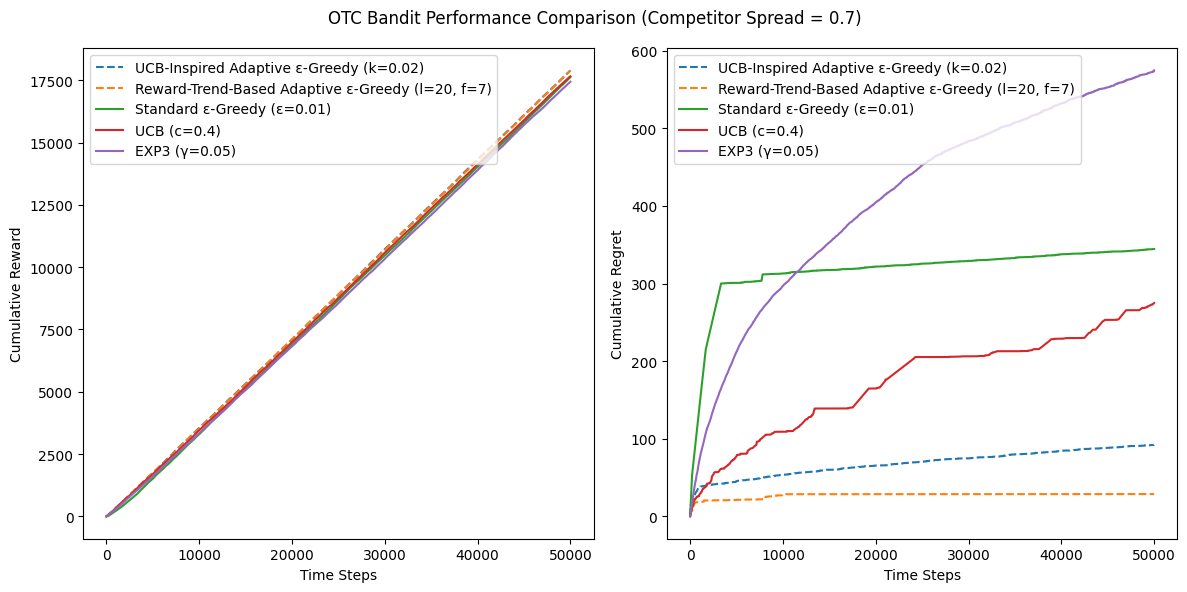

In [77]:
"""
Multi-Armed Bandit Algorithms in OTC (Order-to-Cover) Market Environment
This code compares various bandit algorithms in a simulated financial market scenario
where agents compete through spread selection.
"""

# ==========================
# Setting Evironment
# ==========================
class OTCEnvironment:
    """
    Simulates an Order-to-Cover market environment with spread-based execution probabilities
    
    Parameters:
    - spreads: List of available spreads (arms)
    - competitor_spread: Fixed spread used by market competitor
    - alpha: Market competitiveness parameter (higher = more competitive)
    """
    def __init__(self, spreads, competitor_spread, alpha=0.3):
        self.spreads = np.array(spreads)  # Available spreads (arms)
        self.competitor_spread = competitor_spread  # Fixed competitor spread
        self.alpha = alpha  # Logistic decay steepness (market competitiveness)
        
    def get_execution_prob(self, s):
        return 1 / (1 + np.exp(self.alpha * (s - self.competitor_spread)))
        
    def pull_arm(self, arm):
        """Simulate arm pull with probabilistic reward (spread * execution probability)"""
        s = self.spreads[arm]  # Selected spread
        prob = self.get_execution_prob(s)  # Compute execution probability
        win = np.random.binomial(1, prob)  # Simulate execution (Avellaneda's Poisson intensity)
        return win * s  # Reward = spread * execution (risk-adjusted return from both papers)

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    """
    Run bandit algorithm experiment and track performance metrics
    
    Parameters:
    - bandit_class: Algorithm class to test
    - bandit_params: Dictionary of algorithm parameters
    - env: OTCEvironment instance
    - num_steps: Number of iterations
    
    Returns:
    - cum_rewards: Cumulative correct arm selections
    - cum_regret: Cumulative regret compared to optimal
    """
    bandit = bandit_class(**bandit_params)
    rewards = []
    regrets = []
    spread_history = []  # Track selected arms
    
    # Precompute optimal arm once
    expected_rewards = [s * env.get_execution_prob(s) for s in env.spreads]
    optimal_arm = np.argmax(expected_rewards)
    optimal_reward = expected_rewards[optimal_arm]
    
    for t in range(num_steps):
        arm = bandit.select_arm()
        spread_history.append(arm)
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        
        # Calculate instantaneous regret
        current_expected = env.spreads[arm] * env.get_execution_prob(env.spreads[arm])
        regret = optimal_reward - current_expected
        regrets.append(regret)
        rewards.append(reward)
    
    return np.cumsum(rewards), np.cumsum(regrets), spread_history


# ==========================
# Experiment Setup
# ==========================
num_arms = 10
spreads = np.linspace(0.1, 1, num_arms) # Available spreads
competitor_spread = 0.7 # Competitor's fixed spread
alpha = 4 # High alpha means high competitiveness (steep execution prob curve)
env = OTCEnvironment( # Define environment
    spreads, 
    competitor_spread=competitor_spread,
    alpha=alpha
)
num_steps = 50000  # Simulation length 


# ==========================
# Algorithm Parameters
# ==========================

# UCB-Inspired Adaptive ε-Greedy exploration scaling
k = 0.02  
# Reward-Trend-Based Adaptive ε-Greedy
l = 20
f = 7 
paper_aeg_params = {
    'num_arms': num_arms,
    'l': l,
    'f': f
}
# Standard ε-Greedy exploration rate
epsilon = 0.01  
# UCB exploration weight
c = 0.4 
# EXP3 exploration parameter
gamma = 0.05

# ==========================
# Algorithm Configuration
# ==========================
algo_configs = [
    {   # UCB-Inspired Adaptive ε-Greedy
        'class': UCB_Inspired_Adaptive_Epsilon_Greedy,
        'params': {'num_arms': num_arms, 'k': k},
        'label': f'UCB-Inspired Adaptive ε-Greedy (k={k})'
    },
    {   # Reward-Trend-Based Adaptive ε-Greedy
        'class': Reward_Trend_Based_Adaptive_Epsilon_Greedy,
        'params': {'num_arms': num_arms, 'l': l, 'f': f},
        'label': f'Reward-Trend-Based Adaptive ε-Greedy (l={l}, f={f})'
    },
    {   # Standard ε-Greedy
        'class': EpsilonGreedy,
        'params': {'num_arms': num_arms, 'epsilon': epsilon},
        'label': f'Standard ε-Greedy (ε={epsilon})'
    },
    {   # UCB
        'class': UCB,
        'params': {'num_arms': num_arms, 'c': c},
        'label': f'UCB (c={c})'
    },
    {   # EXP3
        'class': EXP3,
        'params': {'num_arms': num_arms, 'gamma': gamma},
        'label': f'EXP3 (γ={gamma})'
    }
]

# ==========================
# Running Experiment
# ==========================
results = {}
for config in algo_configs:
    key = config['label']
    results[key] = run_experiment(
        config['class'],
        config['params'],
        env,
        num_steps
    )

# ==========================
# Visualization
# ==========================
dashed_lines = 2
plt.figure(figsize=(12, 6))

# Reward Plot
plt.subplot(1, 2, 1)
for idx, (label, (reward_curve, _, _)) in enumerate(results.items()):
    linestyle = '--' if idx < dashed_lines else '-' # First two algorithms get dashed lines
    plt.plot(reward_curve, label=label, linestyle=linestyle)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()

# Regret Plot
plt.subplot(1, 2, 2)
for idx, (label, (_, regret_curve, _)) in enumerate(results.items()):
    linestyle = '--' if idx < dashed_lines else '-'
    plt.plot(regret_curve, label=label, linestyle=linestyle)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.suptitle(f"OTC Bandit Performance Comparison (Competitor Spread = {competitor_spread})")
plt.tight_layout()
plt.show()

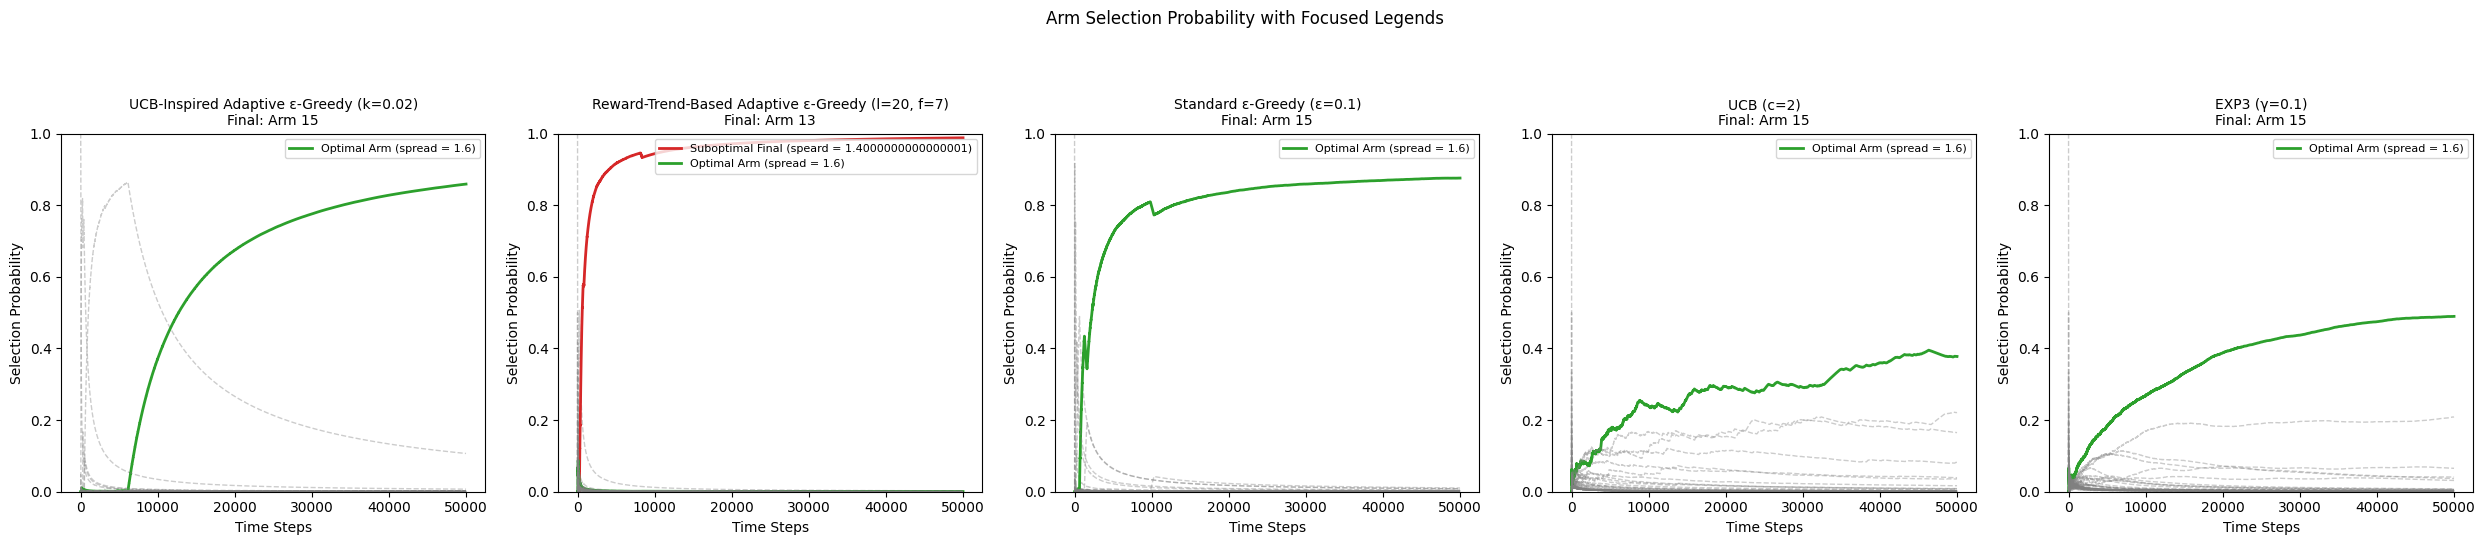

In [33]:
# ==========================
# Visualization: Arm Selection Probability with Focused Legends (FIXED)
# ==========================
plt.figure(figsize=(25, 5))

# Calculate optimal arm once
expected_rewards = [s * env.get_execution_prob(s) for s in env.spreads]
optimal_arm = np.argmax(expected_rewards)

for idx, (algo_label, (_, _, spread_history)) in enumerate(results.items()):  # Changed variable name
    plt.subplot(1, 5, idx+1)
    
    # Find algorithm's most selected arm
    final_arm = np.bincount(spread_history).argmax()
    is_suboptimal = (final_arm != optimal_arm)
    
    # Convert to probability trajectories
    spread_history = np.array(spread_history)
    prob_curves = []
    handles, labels = [], []
    
    for arm_idx in range(num_arms):
        is_selected = (spread_history == arm_idx).astype(float)
        cum_prob = np.cumsum(is_selected) / (np.arange(len(spread_history)) + 1)
        prob_curves.append(cum_prob)
    
    # Plot with legend tracking
    for arm_idx, curve in enumerate(prob_curves):
        color = 'gray'
        alpha = 0.4
        ls = '--'
        lw = 1
        legend_label = None  # Changed variable name
        
        if arm_idx == optimal_arm:
            color = '#2ca02c'
            alpha = 1
            ls = '-'
            lw = 2
            legend_label = f'Optimal Arm (spread = {spreads[optimal_arm]})'
        elif arm_idx == final_arm and is_suboptimal:
            color = '#d62728'
            alpha = 1
            ls = '-'
            lw = 2
            legend_label = f'Suboptimal Final (speard = {spreads[final_arm]})'
        
        line = plt.plot(curve, lw=lw, color=color, 
                       linestyle=ls, alpha=alpha)
        
        if legend_label:  # Only collect non-None labels
            handles.append(line[0])
            labels.append(legend_label)

    # Use original algorithm label for title
    plt.title(f"{algo_label}\nFinal: Arm {final_arm}", fontsize=10)  # Changed variable
    plt.xlabel('Time Steps')
    plt.ylabel('Selection Probability')
    plt.ylim(0, 1)
    if handles:  # Only add legend if we have entries
        plt.legend(handles, labels, loc='upper right', fontsize=8)

plt.suptitle('Arm Selection Probability with Focused Legends', y=1.08)
plt.tight_layout()
plt.show()

In [78]:
# ==========================
# Multi-Trial Evaluation
# ==========================
num_trials = 100
reward_wins = {config['label']: 0 for config in algo_configs}
regret_wins = {config['label']: 0 for config in algo_configs}

for trial in range(num_trials):
    print(trial) if trial % 10 == 0 else None
    # Track performance for current trial
    trial_rewards = {}
    trial_regrets = {}
    
    # Run all algorithms with same environmental conditions
    for config in algo_configs:
        env = OTCEnvironment( # Define environment
            spreads, 
            competitor_spread=competitor_spread,
            alpha=alpha
        )
        cum_reward, cum_regret, _ = run_experiment(
            config['class'],
            config['params'],
            env,
            num_steps
        )
        trial_rewards[config['label']] = cum_reward[-1]
        trial_regrets[config['label']] = cum_regret[-1]
    
    # Update win counters
    max_reward = max(trial_rewards.values())
    min_regret = min(trial_regrets.values())
    
    for algo in algo_configs:
        label = algo['label']
        if trial_rewards[label] == max_reward:
            reward_wins[label] += 1
        if trial_regrets[label] == min_regret:
            regret_wins[label] += 1

# ==========================
# Result Table
# ==========================
import pandas as pd

# Create DataFrame from results
results_df = pd.DataFrame({
    'Algorithm': list(reward_wins.keys()),
    'Reward Wins': list(reward_wins.values()),
    'Regret Wins': list(regret_wins.values())
})

# Sort and format
results_df = (results_df
              .sort_values('Regret Wins', ascending=False)
              .reset_index(drop=True)
              .style
              .set_caption(f'Single-Agent Stationary Performance ({num_trials} Trials)')
              .format({'Regret Wins': '{:.0f}', 'Reward Wins': '{:.0f}'})
              .hide(axis='index')
              .set_properties(**{'text-align': 'left'})
              )

display(results_df)

0
10
20
30


KeyboardInterrupt: 

## Single-Agent Non-Stationary environment

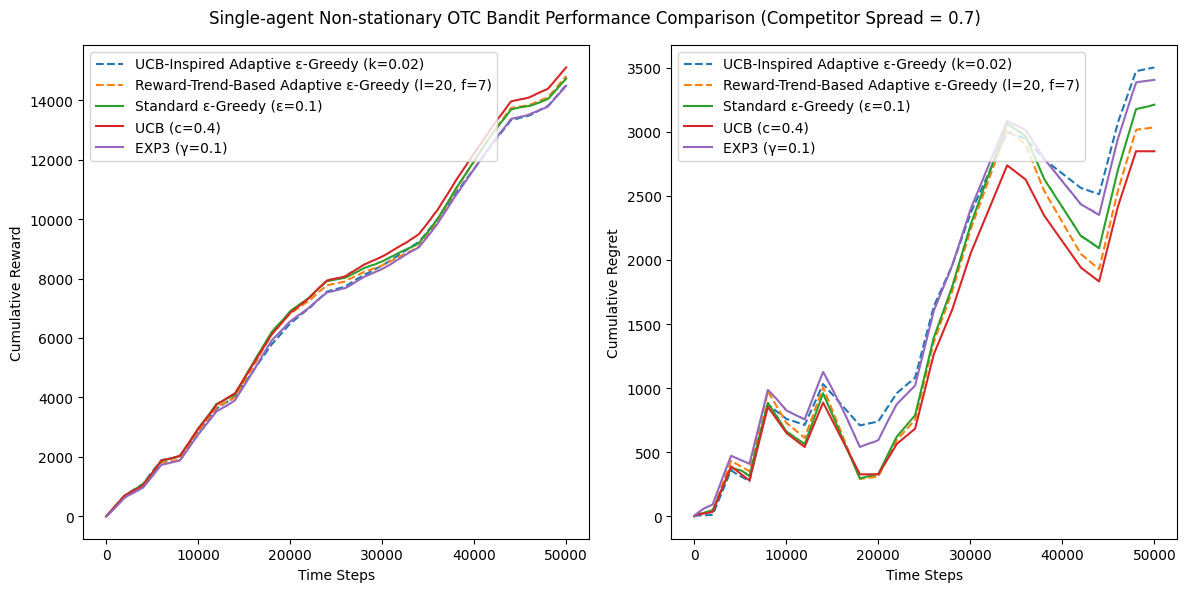

In [44]:
# ==========================
# Non-stationary OTC Environment
# ==========================
class NonStationaryOTCEnvironment(OTCEnvironment):
    """
    Extends OTCEnvironment by periodically changing the competitor's spread,
    simulating a non-stationary environment (e.g., changing market conditions).
    
    Parameters:
    - dynamic_interval: Number of steps between environment changes
    """
    def __init__(self, spreads, competitor_spread=0.7, alpha=4, dynamic_interval=1000, seed=None):
        super().__init__(spreads, competitor_spread, alpha)
        self.dynamic_interval = dynamic_interval
        self.step_counter = 0
        self.rng = np.random.default_rng(seed)  # Use a dedicated RNG with seed

    def update_competitor_spread(self):
        """Periodically update competitor_spread to simulate market drift."""
        if self.step_counter % self.dynamic_interval == 0:
            old = self.competitor_spread
            self.competitor_spread = self.rng.choice(self.spreads)  # Use seeded RNG
            #print(f"[Step {self.step_counter}] Competitor spread changed: {old} ➜ {self.competitor_spread}")

    def pull_arm(self, arm):
        """Override with time-dependent spread change"""
        self.step_counter += 1
        self.update_competitor_spread()
        return super().pull_arm(arm)
    
# ==========================
# Experiment Runner
# ==========================
def run_non_stationary_experiment(bandit_class, bandit_params, env_params, num_steps):
    """Creates a new environment for each experiment."""
    env = NonStationaryOTCEnvironment(**env_params)
    return run_experiment(bandit_class, bandit_params, env, num_steps)

# ==========================
# Experiment Setup
# ==========================
competitor_spread = 0.7 # Competitor's start spread
alpha = 4 # High alpha means high competitiveness (steep execution prob curve)
dynamic_interval = 2000
seed = np.random.randint(10000)  # Random integer
# Parameters for environment initialization
env_params = {
    'spreads': spreads,
    'competitor_spread': competitor_spread,
    'alpha': alpha,
    'dynamic_interval': dynamic_interval,
    'seed' : seed
}
pt = 0

# ==========================
# Running Experiment
# ==========================
results = {}
for config in algo_configs:
    key = config['label']
    results[key] = run_non_stationary_experiment(
        config['class'],
        config['params'],
        env_params,
        num_steps
    )

# ==========================
# Visualization
# ==========================
dashed_lines = 2
plt.figure(figsize=(12, 6))

# Reward Plot
plt.subplot(1, 2, 1)
for idx, (label, (reward_curve, _, _)) in enumerate(results.items()):
    linestyle = '--' if idx < dashed_lines else '-' # First two algorithms get dashed lines
    plt.plot(reward_curve, label=label, linestyle=linestyle)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()

# Regret Plot
plt.subplot(1, 2, 2)
for idx, (label, (_, regret_curve, _)) in enumerate(results.items()):
    linestyle = '--' if idx < dashed_lines else '-'
    plt.plot(regret_curve, label=label, linestyle=linestyle)
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.suptitle(f"Single-agent Non-stationary OTC Bandit Performance Comparison (Competitor Spread = {competitor_spread})")
plt.tight_layout()
plt.show()

In [15]:
# single ns
import numpy as np
import pandas as pd

# ==========================
# Experiment Configuration
# ==========================

num_trials = 100
k_values = np.linspace(0.01, 0.1, 10)  # Example k values

env_params = {
    'spreads': spreads,
    'competitor_spread': competitor_spread,
    'alpha': alpha,
    'dynamic_interval': dynamic_interval,
    'seed' : seed
}

# ==========================
# Running Trials
# ==========================
reward_counts = {k: 0 for k in k_values}
regret_counts = {k: 0 for k in k_values}

for trial in range(num_trials):
    trial_rewards = {}
    trial_regrets = {}
    for k in k_values:
        cum_rewards, cum_regrets, _ = run_non_stationary_experiment(
            UCB_Inspired_Adaptive_Epsilon_Greedy, 
            {'num_arms': num_arms, 'k': k}, 
            env_params, 
            num_steps
            )
        trial_rewards[k] = cum_rewards[-1]
        trial_regrets[k] = cum_regrets[-1]
    
    # Update counts for highest reward
    max_reward = max(trial_rewards.values())
    best_reward_ks = [k for k, v in trial_rewards.items() if v == max_reward]
    reward_counts[best_reward_ks[0]] += 1
    
    # Update counts for lowest regret
    min_regret = min(trial_regrets.values())
    best_regret_ks = [k for k, v in trial_regrets.items() if v == min_regret]
    regret_counts[best_regret_ks[0]] += 1

    if trial % 10 == 0:
        print(trial)

# ==========================
# Creating Results Table
# ==========================
results = []
for k in k_values:
    results.append({
        'k': f"{k:.3f}",
        'Reward Wins': reward_counts[k],
        'Regret Wins': regret_counts[k]
    })

# Sort by Regret Wins ascending (lowest regret first)
results_df = (pd.DataFrame(results)
              .sort_values(by='Regret Wins', ascending=False)
              .reset_index(drop=True)
              .style
              .set_caption(f'Adaptive Epsilon-Greedy Performance Over {num_trials} Trials')
              )
display(results_df)


0
10
20
30
40
50
60
70
80
90


,k,Reward Wins,Regret Wins
0,0.020,22,20
1,0.030,13,16
2,0.050,9,13
3,0.070,11,11
4,0.060,9,10
5,0.080,9,9
6,0.040,7,8
7,0.010,8,5
8,0.090,8,4
9,0.100,4,4


In [27]:

# ==========================
# Multi-Trial Evaluation
# ==========================
num_trials = 100
reward_wins = {config['label']: 0 for config in algo_configs}
regret_wins = {config['label']: 0 for config in algo_configs}

for trial in range(num_trials):
    print(trial) if trial % 10 == 0 else None
    # New random seed for each trial
    trial_seed = np.random.randint(0, 10000)
    trial_env_params = env_params.copy()
    trial_env_params['seed'] = trial_seed
    
    # Track performance for current trial
    trial_rewards = {}
    trial_regrets = {}
    
    # Run all algorithms with same environmental conditions
    for config in algo_configs:
        env = NonStationaryOTCEnvironment(**trial_env_params)
        cum_reward, cum_regret, _ = run_non_stationary_experiment(
            config['class'],
            config['params'],
            env_params,
            num_steps
        )
        trial_rewards[config['label']] = cum_reward[-1]
        trial_regrets[config['label']] = cum_regret[-1]
    
    # Update win counters
    max_reward = max(trial_rewards.values())
    min_regret = min(trial_regrets.values())
    
    for algo in algo_configs:
        label = algo['label']
        if trial_rewards[label] == max_reward:
            reward_wins[label] += 1
        if trial_regrets[label] == min_regret:
            regret_wins[label] += 1

# ==========================
# Result Table
# ==========================
import pandas as pd

# Create DataFrame from results
results_df = pd.DataFrame({
    'Algorithm': list(reward_wins.keys()),
    'Reward Wins': list(reward_wins.values()),
    'Regret Wins': list(regret_wins.values())
})

# Sort by Regret Wins (descending) and format
results_df = (results_df
              .sort_values('Regret Wins', ascending=False)
              .reset_index(drop=True)
              .style
              .set_caption(f'Single-agent Non-Staionary Performance ({num_trials} Trials)')
              .format({'Regret Wins': '{:.0f}', 'Reward Wins': '{:.0f}'})
              .hide(axis='index')
              .set_properties(**{'text-align': 'left'}))

display(results_df)

0
10
20
30
40
50
60
70
80
90


Algorithm,Reward Wins,Regret Wins
"Reward-Trend-Based Adaptive ε-Greedy (l=20, f=7)",59,61
UCB-Inspired Adaptive ε-Greedy (k=0.02),26,26
Standard ε-Greedy (ε=0.1),15,13
UCB (c=2),0,0
EXP3 (γ=0.1),0,0


## Multi-Agent Non-Stationary environment

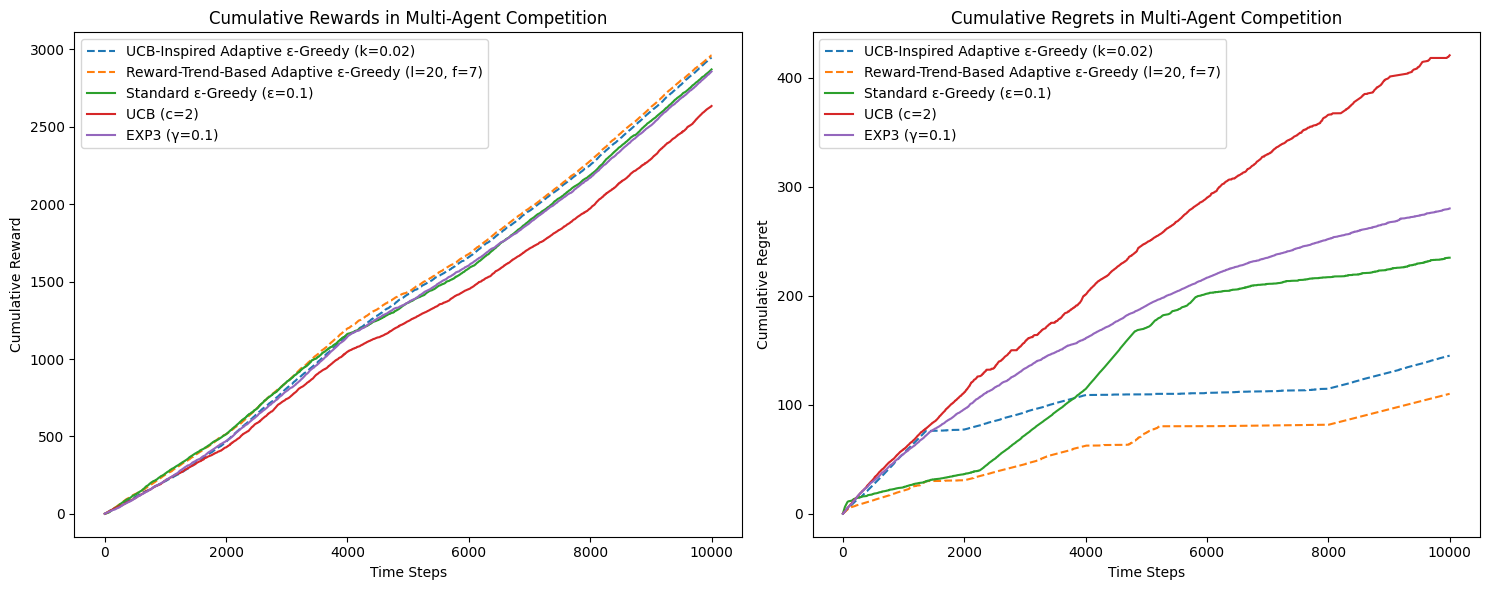

In [28]:
# ==========================
# Multi-Agent Environment
# ==========================
class MultiAgentOTCEnvironment:
    """
    Simulates competitive market with multiple adaptive agents
    Aligns execution probabilities with single-agent OTCEnvironment logic
    """
    def __init__(self, spreads, num_agents=2, alpha=0.4, dynamic_interval=2000):
        self.spreads = np.array(spreads)
        self.num_agents = num_agents
        self.alpha = alpha
        self.dynamic_interval = dynamic_interval
        self.step_counter = 0
        self.competitor_spread = np.median(spreads)  # Initial competitor spread
        self.optimal_spread = None  # Track current optimal spread
        self._update_optimal_spread()  # Critical initialization
        
    def get_execution_prob(self, s):
        return 1 / (1 + np.exp(self.alpha * (s - self.competitor_spread)))
    
    def update_competitor_spread(self):
        """Non-stationary dynamics: Change competitor spread periodically"""
        if self.step_counter % self.dynamic_interval == 0:
            # Move competitor spread randomly within interquartile range
            q1, q3 = np.quantile(self.spreads, [0.25, 0.75])
            self.competitor_spread = np.random.choice(
                self.spreads[(self.spreads >= q1) & (self.spreads <= q3)]
            )
            # Update optimal spread for regret calculation
            self._update_optimal_spread()
            
    def _update_optimal_spread(self):
        """Find current optimal spread considering competitor"""
        expected_rewards = [s * self.get_execution_prob(s) for s in self.spreads]
        self.optimal_spread = self.spreads[np.argmax(expected_rewards)]
    
    def pull_arms(self, arms):
        """Return rewards and instantaneous regrets"""
        self.step_counter += 1
        self.update_competitor_spread()
        
        rewards = []
        regrets = []
        selected_spreads = self.spreads[arms]
        
        # Get current optimal expected reward
        optimal_expected = self.optimal_spread * self.get_execution_prob(self.optimal_spread)
        
        for s in selected_spreads:
            prob = self.get_execution_prob(s)
            reward = np.random.binomial(1, prob) * s
            expected = s * prob
            regret = optimal_expected - expected
            
            rewards.append(reward)
            regrets.append(regret)
            
        return rewards, regrets

# ==========================
# Experiment Runner
# ==========================
def run_multi_agent_experiment(agent_configs, env_params, num_steps):
    """
    Returns:
    - cumulative_rewards: List of arrays (cumulative sum per agent)
    - cumulative_regrets: List of arrays (cumulative sum per agent) 
    - spread_history: Matrix of selected spreads
    """
    env = MultiAgentOTCEnvironment(**env_params)
    num_agents = env_params['num_agents']
    
    # Initialize agents and metrics
    agents = [cls(**params) for cls, params in agent_configs]
    reward_history = np.zeros((num_steps, num_agents))
    regret_history = np.zeros((num_steps, num_agents))
    spread_history = np.zeros((num_steps, num_agents))
    
    for t in range(num_steps):
        arms = [agent.select_arm() for agent in agents]
        spread_history[t] = env.spreads[arms]
        
        # Get rewards and regrets
        rewards, regrets = env.pull_arms(arms)
        
        # Update agents and store metrics
        for i in range(num_agents):
            agents[i].update(arms[i], rewards[i])
            reward_history[t,i] = rewards[i]
            regret_history[t,i] = regrets[i]
    
    return np.cumsum(reward_history, axis=0), np.cumsum(regret_history, axis=0), spread_history

# ==========================
# Experiment Setup
# ==========================
num_arms = 10
spreads = np.linspace(0.1, 1, num_arms)
num_steps = 10000  # Simulation length 
alpha = 4 # High alpha means high competitiveness (steep execution prob curve)
dynamic_interval = 2000
# Agent configurations (mixed strategies)
agent_configs = [
    {   # UCB-Inspired Adaptive ε-Greedy
        'class': UCB_Inspired_Adaptive_Epsilon_Greedy,
        'params': {'num_arms': num_arms, 'k': k},
        'label': f'UCB-Inspired Adaptive ε-Greedy (k={k})'
    },
    {   # Reward-Trend-Based Adaptive ε-Greedy
        'class': Reward_Trend_Based_Adaptive_Epsilon_Greedy,
        'params': {'num_arms': num_arms, 'l': l, 'f': f},
        'label': f'Reward-Trend-Based Adaptive ε-Greedy (l={l}, f={f})'
    },
    {   # Standard ε-Greedy
        'class': EpsilonGreedy,
        'params': {'num_arms': num_arms, 'epsilon': epsilon},
        'label': f'Standard ε-Greedy (ε={epsilon})'
    },
    {   # UCB
        'class': UCB,
        'params': {'num_arms': num_arms, 'c': c},
        'label': f'UCB (c={c})'
    },
    {   # EXP3
        'class': EXP3,
        'params': {'num_arms': num_arms, 'gamma': gamma},
        'label': f'EXP3 (γ={gamma})'
    }
]

# Environment parameters
env_params = {
    'spreads': spreads,
    'num_agents': len(agent_configs),
    'alpha': alpha,
    'dynamic_interval': dynamic_interval
}
# Convert config to tuple format needed by runner
agent_tuples = [(cfg['class'], cfg['params']) for cfg in agent_configs]

# ==========================
# Running Experiments
# ==========================
cumulative_rewards, cumulative_regrets, spread_history = run_multi_agent_experiment(
    agent_tuples,
    env_params,
    num_steps=num_steps
)

# ==========================
# Visualization
# ==========================
dashed_lines = 2
plt.figure(figsize=(15, 6))

# Reward plot
plt.subplot(1, 2, 1)

for i in range(cumulative_rewards.shape[1]):
    linestyle = '--' if i < dashed_lines else '-'
    plt.plot(cumulative_rewards[:,i], 
             label=agent_configs[i]['label'], 
             linestyle=linestyle)
plt.title("Cumulative Rewards in Multi-Agent Competition")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()

# Regret plot
plt.subplot(1, 2, 2)
for i in range(cumulative_regrets.shape[1]):
    linestyle = '--' if i < dashed_lines else '-'
    plt.plot(cumulative_regrets[:, i], 
             label=agent_configs[i]['label'], 
             linestyle=linestyle)
plt.title("Cumulative Regrets in Multi-Agent Competition")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ==========================
# k Optimization Experiment
# ==========================
import numpy as np
import pandas as pd

# Configuration
num_trials = 100
k_values = np.linspace(0.01, 0.1, 10)  # Range of k values to test
agent_tuples = [(cfg['class'], cfg['params']) for cfg in agent_configs]
# ==========================
# Trial Runner
# ==========================
reward_wins = {k: 0 for k in k_values}
regret_wins = {k: 0 for k in k_values}

for trial in range(num_trials):
    print(trial) if trial % 10 == 0 else None
    
    trial_rewards = {}
    trial_regrets = {}
    
    for k in k_values:
        # Configure agents with current k for first agent
        agent_configs[0] = {   # UCB-Inspired Adaptive ε-Greedy
        'class': UCB_Inspired_Adaptive_Epsilon_Greedy,
        'params': {'num_arms': num_arms, 'k': k},
        'label': f'UCB-Inspired Adaptive ε-Greedy (k={k})'
        }
        agent_tuples[0] = (agent_configs[0]['class'], agent_configs[0]['params'])
        # Run experiment
        cum_rewards, cum_regrets, _ = run_multi_agent_experiment(
            agent_tuples,
            env_params,
            num_steps=num_steps
        )
        
        # Track first agent's performance
        trial_rewards[k] = cum_rewards[-1, 0]  # Last step reward
        trial_regrets[k] = cum_regrets[-1, 0]   # Last step regret

    # Update win counts
    max_reward = max(trial_rewards.values())
    best_k_reward = [k for k, v in trial_rewards.items() if v == max_reward][0]
    reward_wins[best_k_reward] += 1
    
    min_regret = min(trial_regrets.values())
    best_k_regret = [k for k, v in trial_regrets.items() if v == min_regret][0]
    regret_wins[best_k_regret] += 1

# ==========================
# Results Analysis
# ==========================
results = []
for k in k_values:
    results.append({
        'k': f"{k:.3f}",
        'Reward Wins': reward_wins[k],
        'Regret Wins': regret_wins[k]
    })

results_df = (pd.DataFrame(results)
              .sort_values(by='Regret Wins', ascending=False)
              .reset_index(drop=True)
              .style
              .set_caption(f'Adaptive Epsilon-Greedy Performance Over {num_trials} Trials')
              )
display(results_df)

0
10
20
30
40
50
60
70
80
90


In [22]:
display(results_df)

,k,Reward Wins,Regret Wins
0,0.030,9,16
1,0.070,6,15
2,0.050,8,12
3,0.020,13,12
4,0.040,9,10
5,0.010,10,8
6,0.090,11,8
7,0.080,10,8
8,0.060,15,6
9,0.100,9,5


In [29]:
# ==========================
# Multi-Trial Evaluation
# ==========================
num_trials = 100
reward_wins = {cfg['label']: 0 for cfg in agent_configs}
regret_wins = {cfg['label']: 0 for cfg in agent_configs}

for trial in range(num_trials):
    print(trial) if trial % 10 == 0 else None
    
    # Run all agents in same environment
    cum_rewards, cum_regrets, _ = run_multi_agent_experiment(
        agent_tuples,
        env_params,
        num_steps=num_steps
    )
    
    # Get final performance metrics
    final_rewards = cum_rewards[-1, :]
    final_regrets = cum_regrets[-1, :]
    
    # Update win counters
    max_reward = np.max(final_rewards)
    min_regret = np.min(final_regrets)
    
    for i, cfg in enumerate(agent_configs):
        label = cfg['label']
        if final_rewards[i] == max_reward:
            reward_wins[label] += 1
        if final_regrets[i] == min_regret:
            regret_wins[label] += 1

# ==========================
# Result Table with Pandas
# ==========================
import pandas as pd

# Create DataFrame from results
results_df = pd.DataFrame({
    'Algorithm': list(reward_wins.keys()),
    'Reward Wins': list(reward_wins.values()),
    'Regret Wins': list(regret_wins.values())
})

# Sort and format
results_df = (results_df
              .sort_values('Regret Wins', ascending=False)
              .reset_index(drop=True)
              .style
              .set_caption(f'Multi-Agent Performance ({num_trials} Trials)')
              .format({'Regret Wins': '{:.0f}', 'Reward Wins': '{:.0f}'})
              .hide(axis='index')
              .set_properties(**{'text-align': 'left'})
              )

display(results_df)

0
10
20
30
40
50
60
70
80
90


Algorithm,Reward Wins,Regret Wins
"Reward-Trend-Based Adaptive ε-Greedy (l=20, f=7)",56,63
UCB-Inspired Adaptive ε-Greedy (k=0.02),29,23
Standard ε-Greedy (ε=0.1),14,13
EXP3 (γ=0.1),1,1
UCB (c=2),0,0
